# Реализация класса dbscan

## Algorithm

DBSCAN(D, eps, MinPts)<br>
   &emsp;C = 0<br>
   &emsp;for each unvisited point P in dataset D<br>
      &emsp;&emsp;mark P as visited<br>
      &emsp;&emsp;NeighborPts = regionQuery(P, eps)<br>
      &emsp;&emsp;if sizeof(NeighborPts) < MinPts<br>
         &emsp;&emsp;&emsp;mark P as NOISE<br>
      &emsp;&emsp;else<br>
         &emsp;&emsp;&emsp;C = next cluster<br>
         &emsp;&emsp;&emsp;expandCluster(P, NeighborPts, C, eps, MinPts)<br>
         
expandCluster(P, NeighborPts, C, eps, MinPts)<br>
   &emsp;add P to cluster C<br>
   &emsp;for each point P' in NeighborPts<br>
      &emsp;&emsp;if P' is not visited<br>
         &emsp;&emsp;&emsp;mark P' as visited<br>
         &emsp;&emsp;&emsp;NeighborPts' = regionQuery(P', eps)<br>
         &emsp;&emsp;&emsp;if sizeof(NeighborPts') >= MinPts<br>
            &emsp;&emsp;&emsp;&emsp;NeighborPts = NeighborPts joined with NeighborPts'<br>
      &emsp;&emsp;if P' is not yet member of any cluster<br>
         &emsp;&emsp;&emsp;add P' to cluster C<br>
         
regionQuery(P, eps)<br>
   &emsp;return all points within P's eps-neighborhood (including P)

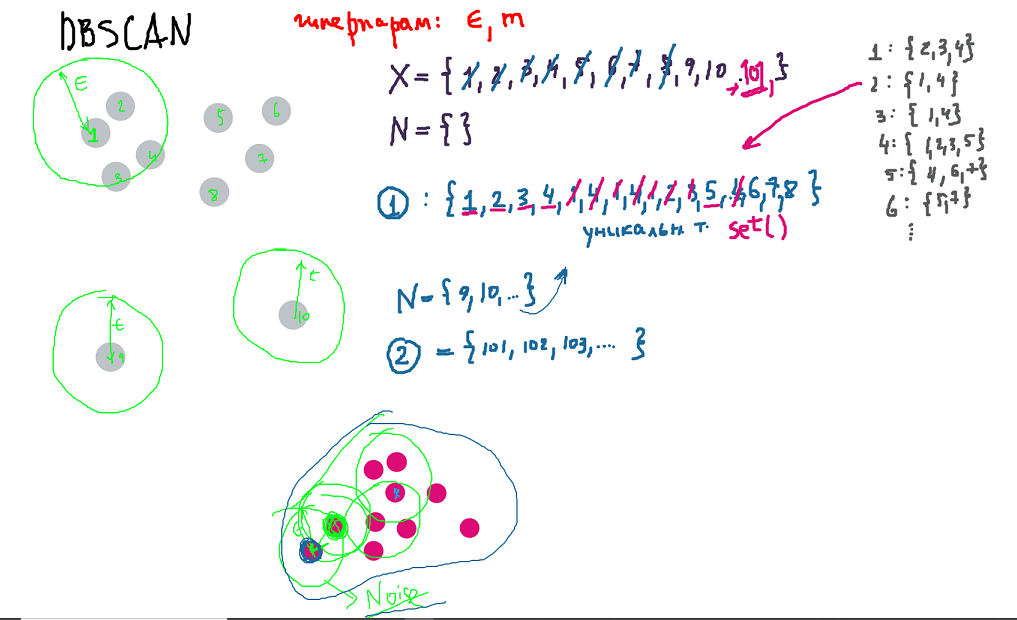

Сгенерируем датасет с помощью pygame

In [1]:
import numpy as np
import matplotlib.pyplot as plt

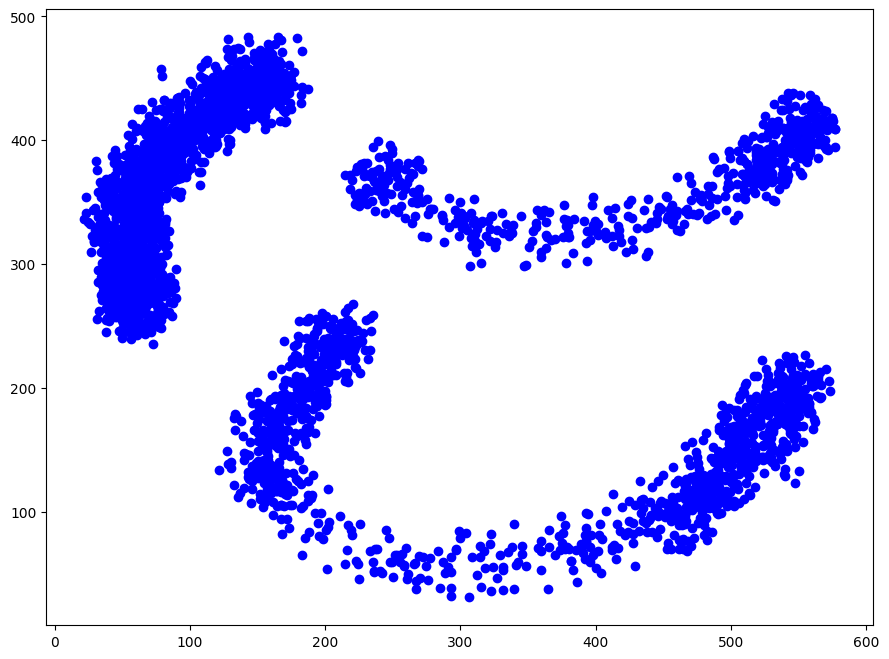

In [3]:
import pygame

points = np.empty((0,2), dtype='f')
    
c_radius = 2
c_color = (0,0,255)
c_thickness = 0 
jet_radius = 30
jet_thr = 0

bg_color = (255,255,255)
(width,height) = (640,480)
screen = pygame.display.set_mode((width,height))
pygame.display.set_caption("data generator")

running = True
pushing = False
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            pushing = False
            
    if pushing and np.random.uniform(0,1)>jet_thr:        
        (x, y) = pygame.mouse.get_pos()
        r = np.random.uniform(0,jet_radius)
        phi = np.random.uniform(0,2*np.pi)
        coord = [x+r*np.cos(phi), height-y+r*np.sin(phi)]
        points = np.append(points, [coord], axis=0)
            
    screen.fill(bg_color)
    for point in points:
        pygame.draw.circle(screen,c_color,(int(point[0]),height-int(point[1])),c_radius,c_thickness)
    pygame.display.flip()
    
pygame.quit()

fig = plt.figure(figsize=(width/60,height/60))
plt.scatter(points[:,0],points[:,1],c="blue")
plt.show()

Сохраним датасет в файл, чтобы его можно было использовать повторно

In [ ]:
np.save('points_2.npy', points)

Загрузим датасет из файла

In [1]:
import numpy as np

points = np.load('points_2.npy')
points

array([[ 46.23819827, 257.30355495],
       [ 57.50091325, 273.82486222],
       [ 57.53601855, 271.83810793],
       ...,
       [194.06600609, 217.62830271],
       [190.85909085, 227.56061849],
       [175.37389275, 223.37031593]])

Добавим в датасет шум

In [2]:
def generate_random_outliers(points, count):
    xy_max = np.amax(points, axis=0)
    xy_min = np.amin(points, axis=0)
    return np.array([(np.random.uniform(xy_min[0], xy_max[0]), np.random.uniform(xy_min[1], xy_max[1]))
                                    for i in range(count)])

points = np.append(points, generate_random_outliers(points, 100), axis=0)
points

array([[ 46.23819827, 257.30355495],
       [ 57.50091325, 273.82486222],
       [ 57.53601855, 271.83810793],
       ...,
       [222.95459139,  32.30120555],
       [379.57763914, 402.43617258],
       [535.13152872,  80.22538962]])

Проведем кластеризацию с помощью DBSCAN из sklearn

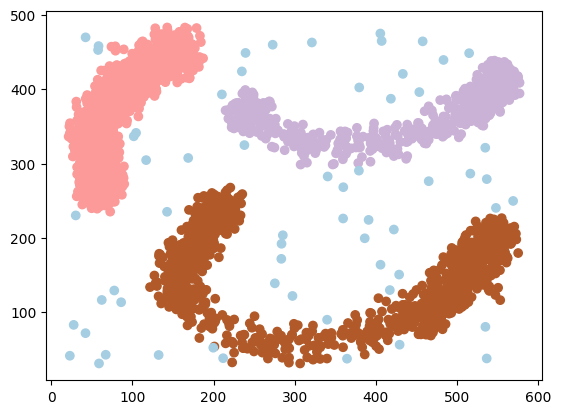

In [3]:
from sklearn.cluster import DBSCAN
labels = DBSCAN(eps=15, min_samples=4).fit_predict(points)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

In [4]:
class DB_SCAN():
    
    def __init__(self, dataset, eps=20., min_samples=5):
        self.dataset = dataset
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        self.clusters = {0:[]}
        self.visited = []
        self.labels = np.array([], dtype='i')
        self.fitted = False
        
    def get_dist(self, list1, list2):
        return np.sqrt(sum([(i-j)**2 for i,j in zip(list1,list2)]))
    
    def get_neighbours(self, P):
        return {tuple(Q) for Q in self.dataset if self.get_dist(Q,P) < self.eps}
    
    def fit(self):
        for P in self.dataset:
            P = list(P)
            if P in self.visited: continue
            self.visited.append(P)
            neighbours = self.get_neighbours(P)
            if len(neighbours) < self.min_samples:
                self.clusters[0].append(P)
            else:
                self.expand_cluster(P)
        self.fitted = True
        
    def expand_cluster(self, P):
        self.n_clusters += 1
        self.clusters[self.n_clusters] = [P]
        neighbours = self.get_neighbours(P)
        while neighbours:
            Q = list(neighbours.pop())
            if Q in self.visited: continue
            self.visited.append(Q)
            self.clusters[self.n_clusters].append(Q)
            Q_neighbours = self.get_neighbours(Q)
            if len(Q_neighbours) > self.min_samples:
                neighbours = neighbours.union(Q_neighbours)
            if Q in self.clusters[0]: self.clusters[0].remove(Q)
                
    def get_labels(self):
        if not self.fitted: self.fit()
        labels = []
        for P in self.dataset:
            for i in range(self.n_clusters+1):
                if list(P) in self.clusters[i]:
                    labels.append(i)
                    break
        self.labels = np.array(labels, dtype='i')
        return self.labels
    
    
dbscan = DB_SCAN(points, eps=21, min_samples=4)
print(dbscan.dataset[123])
dbscan.get_neighbours(dbscan.dataset[123])
labels = dbscan.get_labels()

[ 83.44430012 276.81387239]


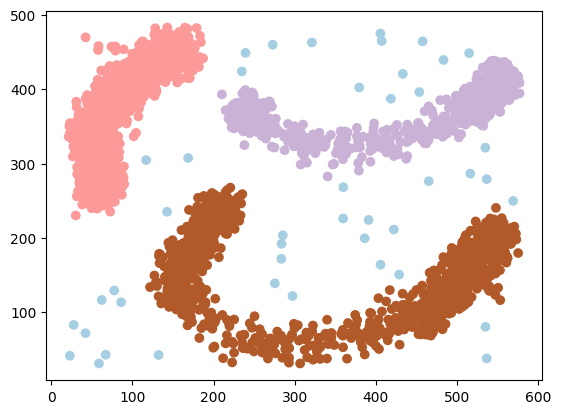

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

https://habr.com/ru/post/322034/

Существуют эвристики для выбора $m$ и $\epsilon$. Чаще всего применяется такой метод и его вариации:

1. Выберите $m$. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять $m$.

2. Вычислите среднее расстояние по $m$ ближайшим соседям для каждой точки. Т.е. если $m=3$, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.

3. Сортируем полученные значения по возрастанию и выводим на экран.

4. Видим что-то вроде такого резко возрастающего графика. Следует взять $\epsilon$ где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше $\epsilon$, тем больше получатся кластеры, и тем меньше их будет.

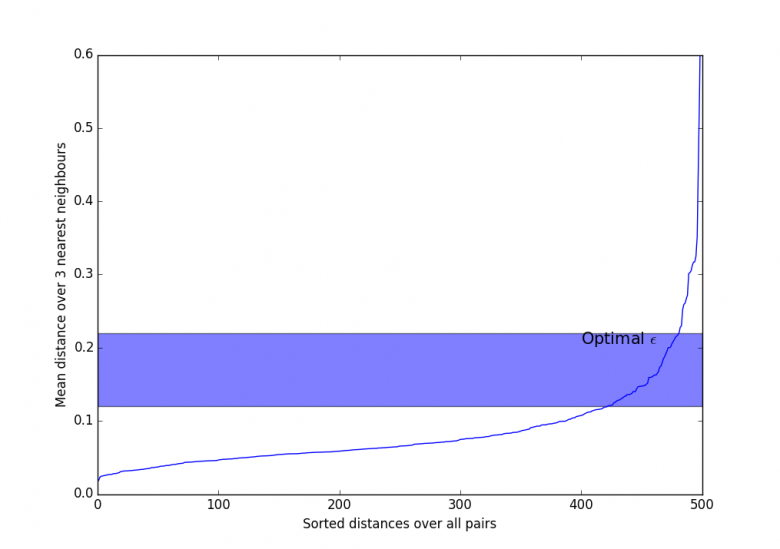

## ДЗ Подбор гиперпараметров метода DB_SCAN

Дано:
- дан класс DB_SCAN кластеризации данных 
Требуется:
- реализовать эвристический метод побора гиперпараметра eps: 

	1. Выберите значение гиперпараметра m. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять m.

	2. Вычислите среднее расстояние по m ближайшим соседям для каждой точки. Т.е. если m=3, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.

	3. Отсортируйте полученные значения по возрастанию и выведите на экран.

	4. Гиперпараметр eps следует взять в полосе, где происходит самый сильный перегиб графика. Чем больше eps, тем больше получатся кластеры, и тем меньше их будет.

- проверить результат подбора параметра eps - показать результат кластеризации для заданного распределение точек при eps меньшим, равным и большим рекомендованного значения
- (не обязательно) попытаться автоматизировать подбор eps согласно эвристики без участия человека  (без построения и анализа графика)

Зададим m

In [6]:
m = 5

Создадим методы, которые будут вычислять среднее расстояние для m ближайших соседей точек

In [7]:
from sklearn.neighbors import NearestNeighbors

def dbscan_distances(data, m):
    nn_result = NearestNeighbors(n_neighbors=m).fit(data).kneighbors(return_distance=True)
    nn_distances = nn_result[0]
    return np.sort(np.average(nn_distances, axis=1))

def plot_dbscan_distances(data, m):
    plt.plot(dbscan_distances(data, m))

Построим график средних расстояний для m ближайших соседей

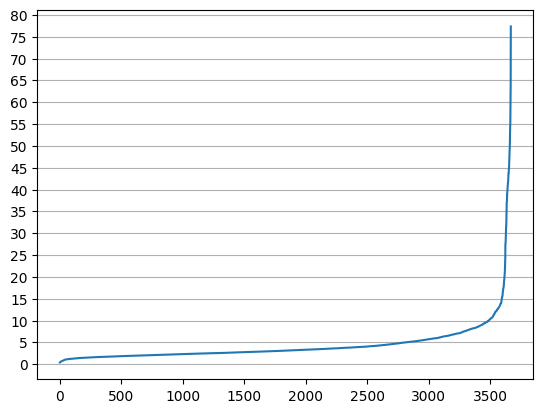

In [8]:
plot_dbscan_distances(points, m)
plt.locator_params(axis='y', nbins=32)
plt.gca().yaxis.grid(True)

Визуально определим полосу самого сильного перегиба графика

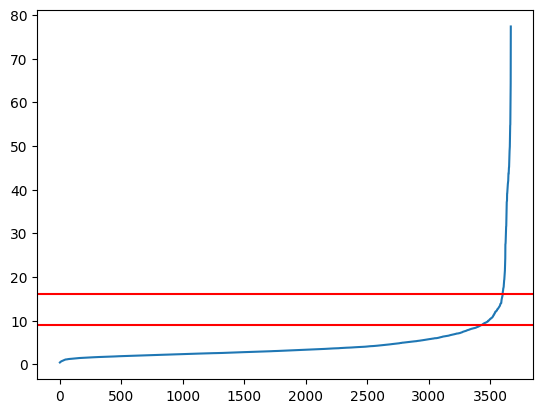

In [9]:
plot_dbscan_distances(points, m)
plt.axhline(y=9, color='r')
plt.axhline(y=16, color='r')

Попробуем разные значения из этой полосы. Видно, что в этой полосе действительно есть хорошие значения eps

In [10]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def run_dbscan(data, m, eps):
    labels = DBSCAN(min_samples=m, eps=eps, n_jobs=-1).fit_predict(data)
    plt.figure()
    plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.Paired)
    plt.show()

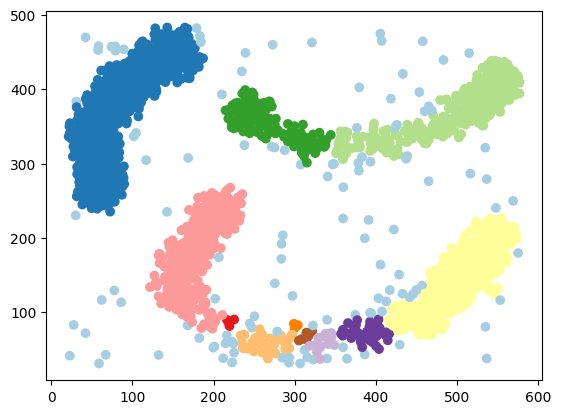

In [11]:
run_dbscan(points, m, 11)

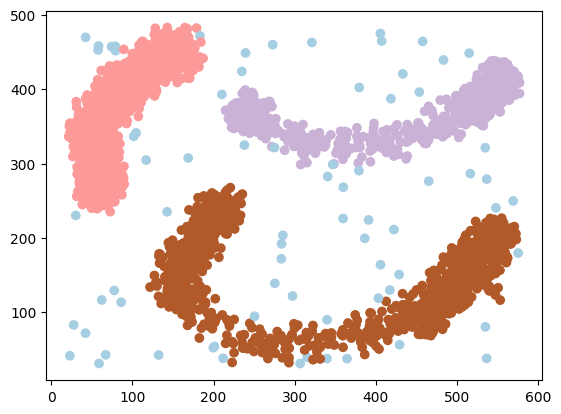

In [12]:
run_dbscan(points, m, 14)

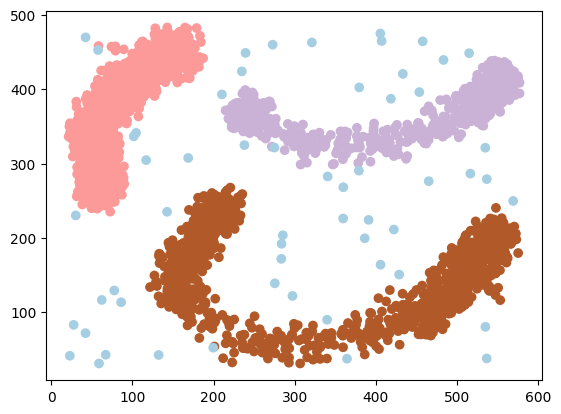

In [13]:
run_dbscan(points, m, 16)

Автоматизируем эвристику. Для этого будем использовать библиотеку, которая ищет точку наибольшего перегиба графика с помощью алгоритма kneedle

In [14]:
%%capture
!pip install kneed[plot]

Найдем точку наибольшего перегиба

In [15]:
from kneed import KneeLocator

def dbscan_optimal_distance(data, m, plot=False):
    distances = dbscan_distances(data, m)
    kneedle = KneeLocator(range(distances.shape[0]), distances, curve='convex')
    elbow = distances[kneedle.knee]
    if plot:
        kneedle.plot_knee()
    return elbow

13.938305980561958

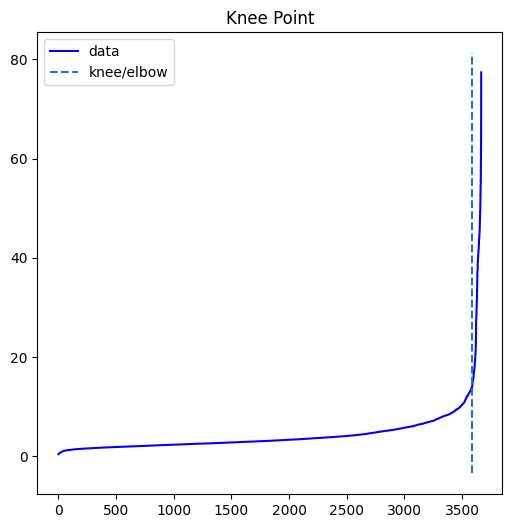

In [16]:
dbscan_optimal_distance(points, m, plot=True)

Найденное эвристикой значение eps действительно приводит к хорошим результатам

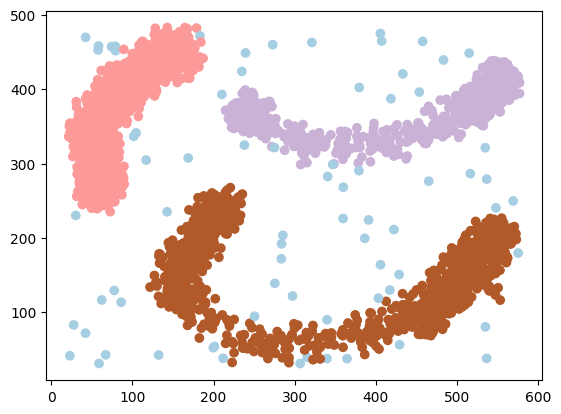

In [17]:
run_dbscan(points, m, dbscan_optimal_distance(points, m))